In [6]:
import hockeypi.games as gm
import hockeypi.teams as tm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.proportion as statsprop
import numpy as np
import matplotlib.colors as mcolors

sns.set()

### Binomial Distribution: Win Loss Confidence Interval

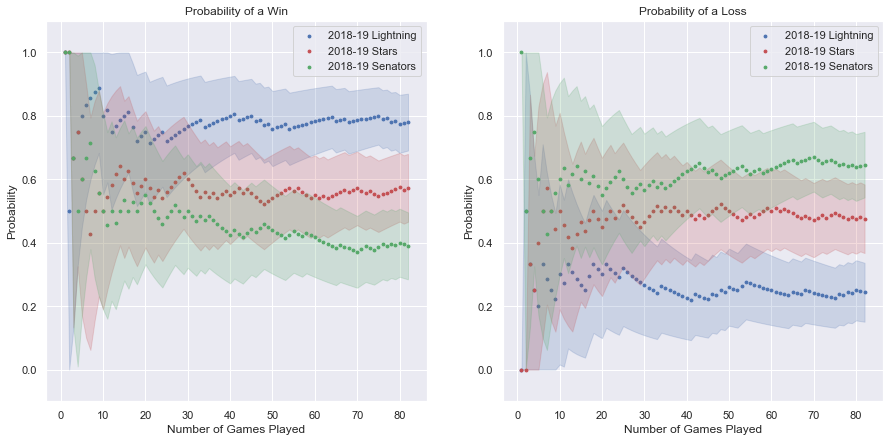

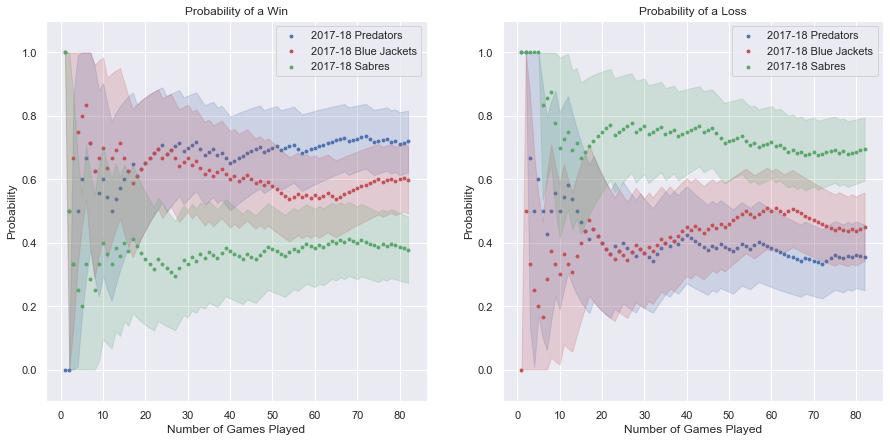

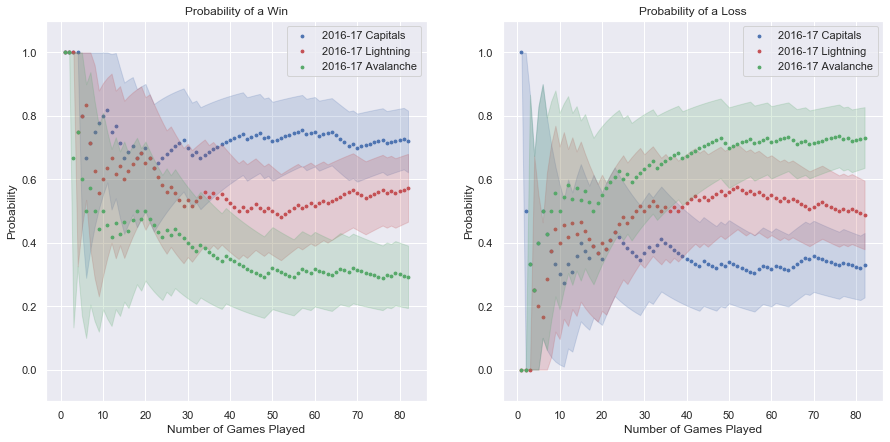

In [10]:
years = [2018, 2017, 2016]

for year in years:
    teams_df = tm.get_all_team_statistics_by_year(year).sort_values(by='pts')
    teams = [get_id_by_place(1, year), get_id_by_place(15, year), get_id_by_place(31, year)]
    get_wl_prob_over_sample_size_plot_with_conf(teams, year)

### Pairwise Z-Tests for Evaluating Stastically Significant Differences

In [11]:
p_mat_2018 = get_p_value_matrix(2018)
print('2018 p-matrix calculated!')
p_mat_2017 = get_p_value_matrix(2017)
print('2017 p-matrix calculated!')
p_mat_2016 = get_p_value_matrix(2016)
print('2016 p-matrix calculated!')

2018 p-matrix calculated!
2017 p-matrix calculated!
2016 p-matrix calculated!


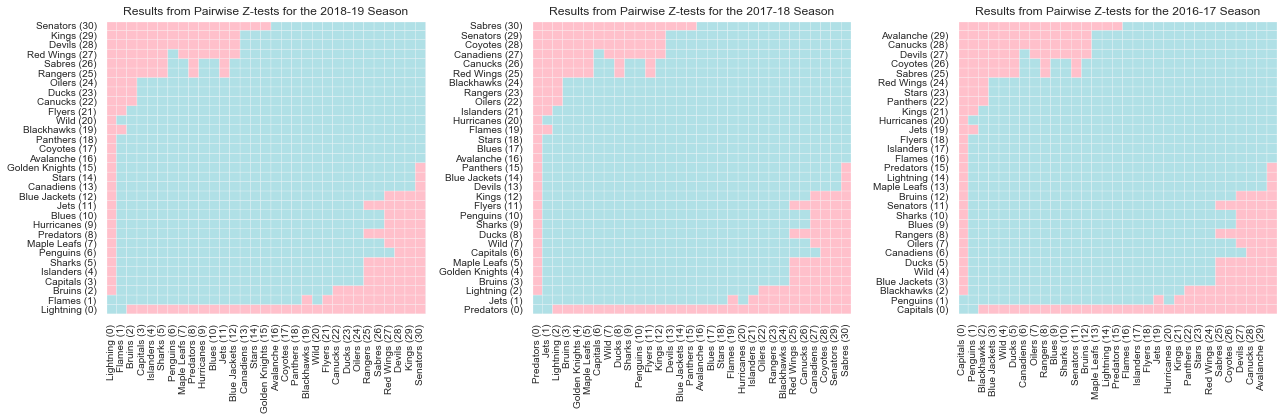

In [30]:
visualize_p_value_matrix([2018, 2017, 2016], [p_mat_2018, p_mat_2017, p_mat_2016])

### Methods for Multinomial Distribution Model

In [29]:
def get_team_regular_season_record(team_id, year):
    ''' 
    Get a dataframe of a team's regular season record.
    The result of each game W/L/OT is appended to each
    row of the dataframe, from the perspective of the 
    specified team ID. 
    '''
    # Get only regular season games within dataframe.  
    df = gm.get_all_games_for_team_by_year(team_id, year)
    reg_df = df[df['gameType'] == 'R'] \
        .sort_values(by='date').reset_index()                   
    reg_df.loc[0, 'result'] = None   
    
    # The NHL API doesn't indicate whether a loss was in
    # regulation or overtime/shoot-out. Rather, it only 
    # reveals the home and away teams' holistic season
    # record after the game was played. Thus, we need
    # keep track of win/loss/ot and use the delta between
    # games to ascertain the outcome of each game.  
    win, loss, ot = 0, 0, 0                                         
    for i in range(len(reg_df)):
        is_home = reg_df.loc[i, 'homeId'] == team_id                 
        prefix = 'home' if is_home else 'away'
        if reg_df.loc[i, f'{prefix}RecordWin'] - win != 0:            
            reg_df.loc[i, 'result'] = 'W'
            win += 1 
        elif reg_df.loc[i, f'{prefix}RecordLoss'] - loss != 0:
            reg_df.loc[i, 'result'] = 'L'
            loss += 1
        elif reg_df.loc[i, f'{prefix}RecordOT'] - ot != 0:
            reg_df.loc[i, 'result'] = 'OT'
            ot += 1
        else: raise Exception('Invalid game delta')
    return reg_df

def get_team_name_by_id(team_id, year):
    '''
    Given a team name and the year of play, return the 
    NHL specified team ID. 
    '''
    df_teams = tm.get_teams_by_year(year)
    return df_teams[df_teams['teamId'] == team_id]['teamName'].item()

def get_team_regular_season_record_list(team_id, year):
    '''
    Get a team's regular season record list, consisting
    of W/L/OT strings (e.g. ['W', 'L', 'OT', 'W' ...])
    '''
    df = get_team_regular_season_record(team_id, year)
    return df['result'].to_list()
    
def get_id_by_place(place, year):
    '''
    Get a team's id by their regular season rank. 
    '''
    teams_df = tm.get_all_team_statistics_by_year(year).sort_values(by='pts')
    return teams_df.tail(place).head(1)['teamId'].item()

def get_wl(record):
    '''
    Get number of wins and losses from a record list,
    collapsing post-regulation losses into wins and losses.
    '''
    w, l, ot = 0, 0, 0
    for res in record:
        if res == 'W': w += 1
        elif res == 'L': l += 1
        else: ot += 1          
    # collapse ordinal categorical variable.
    w += (ot - ot//2)
    l += ot
    return w, l

def get_wl_prob_over_sample_size_plot_with_conf(team_ids, year, figsize=(15,7)):
    '''
    Get a scatter plot of win and loss probabilities
    as well as their respective 95% confidence intervals
    for a list of teams specified by the team ids.
    '''   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    c_list, c_idx = ['b', 'r', 'g', 'm', 'c'], 0

    for team_id in team_ids:
        record = get_team_regular_season_record_list(team_id, year)
        game_idx = [i for i in range(1, len(record) + 1)]
        win_prob, min_win_prob, max_win_prob = [], [], []
        loss_prob, min_loss_prob, max_loss_prob = [], [], []
        
        for idx in game_idx:
            record_considered = record[:idx]
            w, l = get_wl(record_considered)
            conf_w = statsprop.proportion_confint(w, len(record_considered), alpha=0.05)
            conf_l = statsprop.proportion_confint(l, len(record_considered), alpha=0.05)
            win_prob.append(w/len(record_considered))
            loss_prob.append(l/len(record_considered))
            min_win_prob.append(conf_w[0])
            max_win_prob.append(conf_w[1])
            min_loss_prob.append(conf_l[0])
            max_loss_prob.append(conf_l[1])
        
        ax1.scatter(x=game_idx, y=win_prob, s=8, c=c_list[c_idx % len(c_list)], label=f'{year}-{str(year+1).replace("20", "")} {get_team_name_by_id(team_id, year)}')
        ax1.fill_between(game_idx, min_win_prob, max_win_prob, color=c_list[c_idx % len(c_list)], alpha=0.2)  
        ax2.scatter(x=game_idx, y=loss_prob, s=8, c=c_list[c_idx % len(c_list)], label=f'{year}-{str(year+1).replace("20", "")} {get_team_name_by_id(team_id, year)}')
        ax2.fill_between(game_idx, min_loss_prob, max_loss_prob, color=c_list[c_idx % len(c_list)], alpha=0.2)
        c_idx += 1
    
    for ax in (ax1, ax2):
        ax.set_xlabel('Number of Games Played')
        ax.set_ylabel('Probability')
        ax.set_ylim([-0.1, 1.1])
        ax.legend()
    
    ax1.set_title('Probability of a Win')
    ax2.set_title('Probability of a Loss')
    plt.show()

def perform_ztest(team_id1, team_id2, year):
    '''
    Perform a Z-test for the regular season performance
    of two specified team for a given year. 
    '''
    team1_record = get_team_regular_season_record_list(team_id1, year)
    team2_record = get_team_regular_season_record_list(team_id2, year)
    w1, l1 = get_wl(team1_record)
    w2, l2 = get_wl(team2_record)
    return statsprop.proportions_ztest([w1, w2], [w1+l1, w2+l2])

def get_p_value_matrix(year):
    '''
    Get p-values from pairwise Z-tests performed on the regular
    season performances of all teams in a given year. 
    '''
    team_ids_by_pts = tm.get_all_team_statistics_by_year(year) \
        .sort_values(by='pts')[::-1]['teamId'].to_list()
    p_matrix = []
    for i in range(len(team_ids_by_pts)):
        p_list = []
        for j in range(len(team_ids_by_pts)):
            p_list.append(perform_ztest(team_ids_by_pts[i], team_ids_by_pts[j], year)[1])
        p_matrix.append(p_list)
    return p_matrix

def visualize_p_value_matrix(years, p_mats):
    '''
    Produce a visual for the pairwise p-value matrix.
    '''
    fig, ax = plt.subplots(1, len(years), figsize=(18, 6))
    cmap, norm = mcolors.from_levels_and_colors([0, 0.05, 1.01], ['pink', 'powderblue'])

    for i in range(len(years)):
        year = years[i]
        p_mat = p_mats[i]       
        team_ids_by_pts = tm.get_all_team_statistics_by_year(year).sort_values(by='pts')[::-1]['teamId'].to_list()
        team_names = [f'{get_team_name_by_id(team_ids_by_pts[i], year)} ({i})' for i in range(len(team_ids_by_pts))]
        ax[i].pcolor(p_mat_2018, cmap=cmap, norm=norm, edgecolors='w')
        ax[i].tick_params(axis='both', labelsize=10)
        ax[i].set_yticks(np.arange(0.5, len(team_names), 1))
        ax[i].set_yticklabels(team_names)
        ax[i].set_xticks(np.arange(0.5, len(team_names), 1))
        ax[i].set_xticklabels(team_names, rotation=90)
        ax[i].set_title(f'Results from Pairwise Z-tests for the {year}-{str(year+1).replace("20", "")} Season')
        
    plt.tight_layout()
    plt.show()